# Choosing features

In [1]:
import numpy as np

# Define the model mapping
groq_models = {
    "llama3-70b": "llama3-70b-8192",
    "mixtral": "mixtral-8x7b-32768",
    "gemma-7b": "gemma-7b-it",
    "llama3.1-70b": "llama-3.1-70b-versatile",
    "llama3-8b": "llama3-8b-8192",
    "llama3.1-8b": "llama-3.1-8b-instant",
    "gemma-9b": "gemma2-9b-it"
}

activity_labels = {
    1: "WALKING",
    2: "WALKING_UPSTAIRS",
    3: "WALKING_DOWNSTAIRS",
    4: "SITTING",
    5: "STANDING",
    6: "LAYING"
}
reverse_activity_labels = {v: k for k, v in activity_labels.items()}

print("Activity Labels Dictionary: ", reverse_activity_labels)

# Load datasets
X_train = np.load('../FinalDataset/X_train.npy')
X_test = np.load('../FinalDataset/X_test.npy')
y_train = np.load('../FinalDataset/y_train.npy')
y_test = np.load('../FinalDataset/y_test.npy')

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)


Activity Labels Dictionary:  {'WALKING': 1, 'WALKING_UPSTAIRS': 2, 'WALKING_DOWNSTAIRS': 3, 'SITTING': 4, 'STANDING': 5, 'LAYING': 6}
X_train shape:  (126, 500, 3)
X_test shape:  (54, 500, 3)
y_train shape:  (126,)
y_test shape:  (54,)


In [12]:

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import tsfel

# Extract features using TSFEL
cfg = tsfel.get_features_by_domain()  # Get all features by default
X_train_features = tsfel.time_series_features_extractor(cfg, X_train, verbose=1, fs=50)
X_test_features = tsfel.time_series_features_extractor(cfg, X_test, verbose=1, fs=50)

# Remove highly correlated features
correlated_features = tsfel.correlated_features(X_train_features)
X_train_filtered = X_train_features.drop(correlated_features, axis=1)
X_test_filtered = X_test_features.drop(correlated_features, axis=1)

# Remove low variance features
variance_selector = VarianceThreshold(threshold=0)
X_train_reduced = variance_selector.fit_transform(X_train_filtered)
X_test_reduced = variance_selector.transform(X_test_filtered)

# Normalize features
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train_reduced)
X_test_normalized = scaler.transform(X_test_reduced)

# Apply PCA

pca = PCA(n_components=20)
X_train_pca_20 = pca.fit_transform(X_train_normalized)
X_test_pca_20 = pca.transform(X_test_normalized)

print("X_train_pca shape: ", X_train_pca_20.shape)
print("X_test_pca shape: ", X_test_pca_20.shape)

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
X_train_pca shape:  (126, 20)
X_test_pca shape:  (54, 20)


TypeError: Object of type ndarray is not JSON serializable

In [13]:
import json
with open('X_train_pca_20.json', 'w') as f:
    json.dump({'X_train_pca_20': X_train_pca_20.tolist()}, f)

with open('y_train.json', 'w') as f:
    json.dump({'y_train': y_train.tolist()}, f)

In [3]:
import pandas as pd

print("PCA Explained Variance: ", pca.explained_variance_ratio_)
print("PCA Explained Variance Sum: ", sum(pca.explained_variance_ratio_))

PCA Explained Variance:  [0.28703436 0.03779491 0.03279605 0.03077334 0.02917738 0.02607341
 0.02319793 0.02129972 0.02048859 0.01976077 0.01824957 0.01780066
 0.0166256  0.0163884  0.01613402 0.01469195 0.01464103 0.01351642
 0.01304109 0.01286107]
PCA Explained Variance Sum:  0.6823462674804235


In [4]:
from sklearn.tree import DecisionTreeClassifier
import pandas as pd


# Fit a Decision Tree classifier to get feature importances
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train_normalized, y_train)

# Get feature importances
importances = clf.feature_importances_
# Number of top features you want
N = 6
# Get indices of the top N features
top_indices = np.argsort(importances)[-N:]

filtered_feature_names = X_train_filtered.columns
# Get feature names corresponding to the top N features
top_feature_names = [filtered_feature_names[i] for i in top_indices]

# Select the top N important features from the datasets
X_test_important = X_test_normalized[:, top_indices]



# Display the shapes and feature names
print("X_test_important shape: ", X_test_important.shape)
print("Top feature names: ", top_feature_names)


# Display the dataframes with the top features
df_test_important = pd.DataFrame(X_test_important, columns=top_feature_names)

prefix_map = {
    '0': 'x',
    '1': 'y',
    '2': 'z',
    '3': 'linear_acceleration'
}

# Create a new column name mapping
new_columns = {}
for col in df_test_important.columns:
    prefix = col.split('_')[0]
    if prefix in prefix_map:
        new_prefix = prefix_map[prefix]
        new_col_name = col.replace(prefix, new_prefix)
        new_columns[col] = new_col_name

# Rename the columns
df_test_important.rename(columns=new_columns, inplace=True)
top_feature_names = list(df_test_important.columns)

display(df_test_important.head())

X_test_important shape:  (54, 6)
Top feature names:  ['1_FFT mean coefficient_205', '0_Min', '1_MFCC_11', '0_FFT mean coefficient_95', '0_FFT mean coefficient_204', '0_ECDF Percentile Count_0']


,y_FFT mean coefficient_205,x_Min,y_MFCC_yy,x_FFT mean coefficient_95,x_FFT mean coefficient_2x4,x_ECDF Percentile Count_x
0,4.808412,-0.716924,0.874209,1.276809,0.413246,0.111214
1,-0.366802,-0.841201,1.227735,0.116074,-0.311291,0.220641
2,-0.362164,-1.451714,-0.398786,0.645658,-0.150772,-0.190568
3,-0.399911,-0.066238,0.716442,-0.782123,-0.316134,0.918342
4,-0.419538,-0.445348,-0.777930,-0.782280,-0.316125,0.938693


# Zero Shot
Since we aren't giving the labels to the LLM .The only source of information the LLM coud get was from only the training data.<br> So rather than reducing the feature number by PCA , I decided to choose top k features using decision tree feature importance.So that we can provide context to the llm inform of column name.

Test Case 1 (WALKING_DOWNSTAIRS):
Predicted label for the query input: 6
True label for the query input: 3
--------------------------------------------------
Test Case 2 (WALKING):
Predicted label for the query input: 4
True label for the query input: 1
--------------------------------------------------
Test Case 3 (WALKING_UPSTAIRS):
Predicted label for the query input: 4
True label for the query input: 2
--------------------------------------------------
Test Case 4 (STANDING):
Predicted label for the query input: 4
True label for the query input: 5
--------------------------------------------------
Test Case 5 (STANDING):
Predicted label for the query input: 4
True label for the query input: 5
--------------------------------------------------
Test Case 6 (WALKING):
Predicted label for the query input: 4
True label for the query input: 1
--------------------------------------------------
Test Case 7 (WALKING):
Predicted label for the query input: 6
True label for the query input: 1


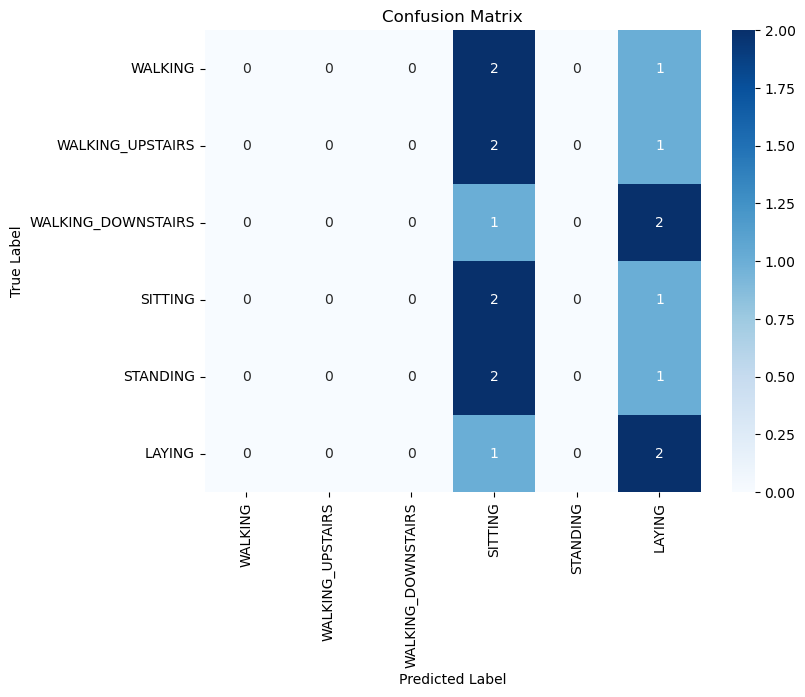

In [5]:
import time
from langchain_groq import ChatGroq
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def make_api_call(prompt):
    while True:
        try:
            response = llm.invoke(prompt)
            return response
        except Exception as e:
            print(f"Rate limit error: {e}. Retrying in 10 seconds...")
            time.sleep(10)  # Wait before retrying

# Set up your Groq API credentials and model
Groq_Token = "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"
model_name = "llama3.1-70b"
llm = ChatGroq(model=groq_models[model_name], api_key=Groq_Token, temperature=0)

# Function to generate a zero-shot prompt
# Function to generate a zero-shot prompt
def create_zero_shot_prompt(query_input, retained_features):
    """Generate a prompt for the model given the JSON formatted data and retained features."""
    # Combine features and their corresponding values in "column:value" format
    features_str = ', '.join([f"{feature}:{value}" for feature, value in zip(retained_features, query_input)])

    description = (f"""
    You are a highly trained human activity classification model.
    Each input is a vector containing numerical values that represent specific features of human activity data.
    The data is presented as pairs of column names and their corresponding values.

    The data consists of {N} features extracted from the Human Activity Recognition dataset. 
    Your task is to analyze the given input vector and classify the human activity into one of the following categories:
    - 1: WALKING
    - 2: WALKING_UPSTAIRS
    - 3: WALKING_DOWNSTAIRS
    - 4: SITTING 
    - 5: STANDING
    - 6: LAYING

    The initial data consisted of:
    - 500 readings, each containing three accelerometer values: (acceleration_x, acceleration_y, acceleration_z).
    - The data is collected over a 10-second period at a sampling rate of 50 Hz, which gives 500 readings.

    Data Format:
    - Static activities tend to have very little variation in the accelerometer data, while dynamic activities tend to have more variation.
    - x axis is the vertical axis, z axis is forward direction, and y axis is the side direction.
    - Acceleration is measured in terms of g-force. At rest, the acceleration is 1 (representing gravity).

    The following input vector represents the selected features and their corresponding values: {features_str}

    Now, classify this input vector into one of the numerical categories (1, 2, 3, 4, 5, 6) and return ONLY the number.
    """)

    return description

# Step 3: Select 3 samples from each activity
selected_indices = []
samples_per_activity = 3
activity_count = {i: 0 for i in range(1, 7)}  # Dictionary to track count of selected samples for each activity

for i, label in enumerate(y_test):
    if activity_count[label] < samples_per_activity:
        selected_indices.append(i)
        activity_count[label] += 1
    if all(count == samples_per_activity for count in activity_count.values()):
        break

# Store predictions and true labels
predictions = []
true_labels = []

# Step 4: Test the selected cases
for idx in selected_indices:
    query_input = X_test_important[idx].tolist()
    true_label = y_test[idx]
    prompt = create_zero_shot_prompt(query_input, top_feature_names)
    
    # Step 5: Make the API call using ChatGroq
    answer = make_api_call(prompt)
    
    # Store predictions and true labels
    predicted_label = int(answer.content.strip())
    
    predictions.append(predicted_label)
    true_labels.append(true_label)
    
    # Print the predicted and true labels
    print(f"Test Case {idx + 1} ({activity_labels[true_label]}):")
    print(f"Predicted label for the query input: {predicted_label}")
    print(f"True label for the query input: {true_label}")
    print("-" * 50)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy:.2f}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions, labels=[1, 2, 3, 4, 5, 6])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], 
            yticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



# Few Shot
PCA is applied on featurised data and passed to LLM for prediction.
30 few shot examples are given to the LLM for learning.

Test Case 1 (WALKING_DOWNSTAIRS):
Predicted label: 1
True label: 3
--------------------------------------------------
Test Case 2 (WALKING):
Predicted label: 3
True label: 1
--------------------------------------------------
Test Case 3 (WALKING_UPSTAIRS):
Predicted label: 2
True label: 2
--------------------------------------------------
Test Case 4 (STANDING):
Predicted label: 5
True label: 5
--------------------------------------------------
Test Case 5 (STANDING):
Predicted label: 5
True label: 5
--------------------------------------------------
Test Case 6 (WALKING):
Predicted label: 1
True label: 1
--------------------------------------------------
Test Case 7 (WALKING):
Predicted label: 1
True label: 1
--------------------------------------------------
Test Case 8 (STANDING):
Predicted label: 5
True label: 5
--------------------------------------------------
Test Case 9 (WALKING_DOWNSTAIRS):
Predicted label: 3
True label: 3
--------------------------------------------------
Tes

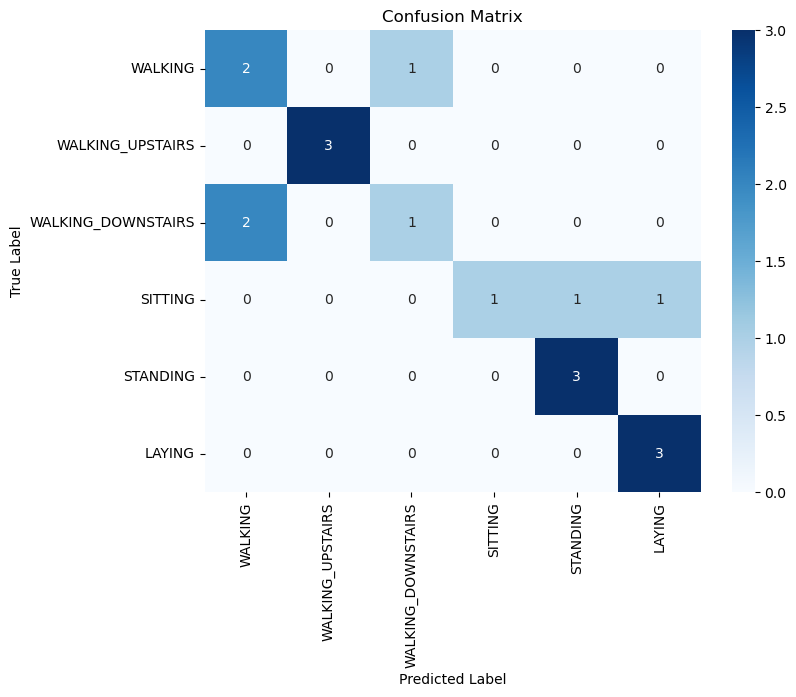

In [6]:
import time
from langchain_groq import ChatGroq
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to make API calls with retry logic for rate limit errors
def make_api_call(prompt):
    while True:
        try:
            response = llm.invoke(prompt)
            return response
        except Exception as e:
            print(f"Rate limit error: {e}. Retrying in 10 seconds...")
            time.sleep(10)

# Set up Groq API credentials and model
Groq_Token = "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"
model_name = "llama3.1-70b"
llm = ChatGroq(model=groq_models[model_name], api_key=Groq_Token, temperature=0)

# Select even samples for few-shot learning examples
samples_per_activity = 5
few_shot_indices = []
activity_count = {i: 0 for i in range(1, 7)}

for i, label in enumerate(y_train):
    if activity_count[label] < samples_per_activity:
        few_shot_indices.append(i)
        activity_count[label] += 1
    if all(count == samples_per_activity for count in activity_count.values()):
        break

# Create few-shot examples
few_shot_examples = [
    {"input": X_train_pca_20[i].tolist(), "label": y_train[i]} for i in few_shot_indices
]

# Function to create a few-shot learning prompt
def create_few_shot_prompt(examples, query_input):
    description = '''
        You are a highly trained human activity classification model.
        Each input is a vector containing numerical values that represent transformed features.
        The data consists of 20 principal components extracted from the Human Activity Recognition dataset.
        Your task is to classify the input vector into one of the following categories:
        - 1: WALKING
        - 2: WALKING_UPSTAIRS
        - 3: WALKING_DOWNSTAIRS
        - 4: SITTING 
        - 5: STANDING
        - 6: LAYING

        Here are a few examples:\n
    '''
    prompt = description
    for ex in examples:
        example_input = ",".join(map(str, ex['input']))
        prompt += f"Input: [{example_input}]\nLabel: {ex['label']}\n\n" 
        
    query_input_str = ",".join(map(str, query_input))
    prompt += f"Now, classify the following input vector and return ONLY the number.\nInput: [{query_input_str}]\nLabel: "
    return prompt

# Select 3 samples from each activity for testing
samples_per_activity = 3
selected_indices = []
activity_count = {i: 0 for i in range(1, 7)}

for i, label in enumerate(y_test):
    if activity_count[label] < samples_per_activity:
        selected_indices.append(i)
        activity_count[label] += 1
    if all(count == samples_per_activity for count in activity_count.values()):
        break

# Store predictions and true labels
predictions = []
true_labels = []

# Test the selected cases
for idx in selected_indices:
    query_input = X_test_pca_20[idx].tolist()
    true_label = y_test[idx]
    prompt = create_few_shot_prompt(few_shot_examples, query_input)
    
    # Make the API call and store the prediction
    answer = make_api_call(prompt)
    predicted_label = int(answer.content.strip())
    predictions.append(predicted_label)
    true_labels.append(true_label)
    
    # Print the predicted and true labels
    print(f"Test Case {idx + 1} ({activity_labels[true_label]}):")
    print(f"Predicted label: {predicted_label}")
    print(f"True label: {true_label}")
    print("-" * 50)

# Calculate and print accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy:.2f}")

# Calculate and plot the confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions, labels=[1, 2, 3, 4, 5, 6])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], 
            yticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


TypeError: Object of type int32 is not JSON serializable

## Question 1: Qualitatively Demonstrate the Performance of Few-Shot Learning with Zero-Shot Learning. Which Method Performs Better? Why?

**Answer:**

In **Zero-Shot Learning**, the LLM tends to classify activities predominantly as either laying or standing. While it correctly identifies sitting, it struggles to distinguish between other activities.

In contrast, in **Few-Shot Learning**, the LLM can more accurately classify activities as either static or dynamic. Since there are no samples that fall into the categories of (1, 2, 3) but are instead classified as (4, 5, 6) or vice versa, the model demonstrates better performance. Specifically:
- **WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, STANDING,** and **LAYING** show improved accuracy, with fewer misclassifications compared to the zero-shot method.
- **SITTING** still has some misclassifications, but overall, it performs better in the few-shot scenario.

**Reason:**
Few-shot learning has an advantage because it provides the model with a small number of labeled examples. This allows the model to adapt and learn from these samples, leading to better classification accuracy.

On the other hand, zero-shot learning solely relies on the model's generalization capabilities without seeing any examples. It doesn't learn anything new but rather predicts based on its prior knowledge, which may not be entirely relevant to the experimental conditions, resulting in more misclassifications.

**Conclusion:**
Few-shot learning outperforms zero-shot learning as it provides better context for making accurate predictions.


## Running Decision Tree on the same few shot examples and testing on the same set of test examples.

In [ ]:


from sklearn.tree import DecisionTreeClassifier

dt=DecisionTreeClassifier(random_state=0)
X_train_dt = [ X_train_pca_20[i].tolist() for i in few_shot_indices]
y_train_dt = [ y_train[i] for i in few_shot_indices ]
dt.fit(X_train_dt,y_train_dt)

DecisionTreeClassifier(random_state=0)

In [ ]:
X_test_dt = [ X_test_pca_20[idx].tolist() for idx in selected_indices]
y_test_dt = [ y_test[idx] for idx in selected_indices ]
y_pred_dt = dt.predict(X_test_dt)

Decision Tree Classifier Results:
Accuracy:  0.5555555555555556
Precision:  0.6130952380952381
Recall:  0.5555555555555556


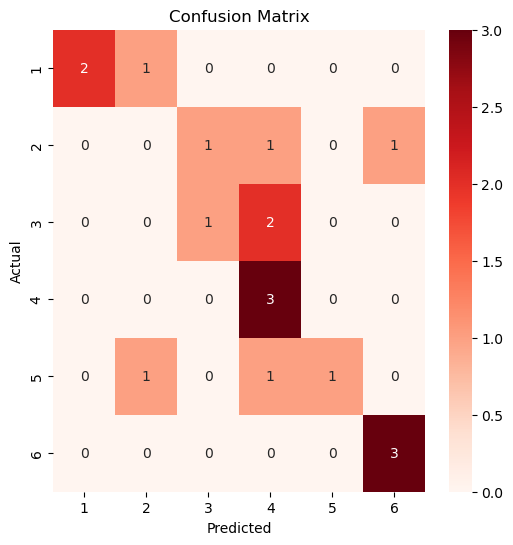

Few Shot Learning Results:
Accuracy:  0.8333333333333334
Precision:  0.8472222222222222
Recall:  0.8333333333333334


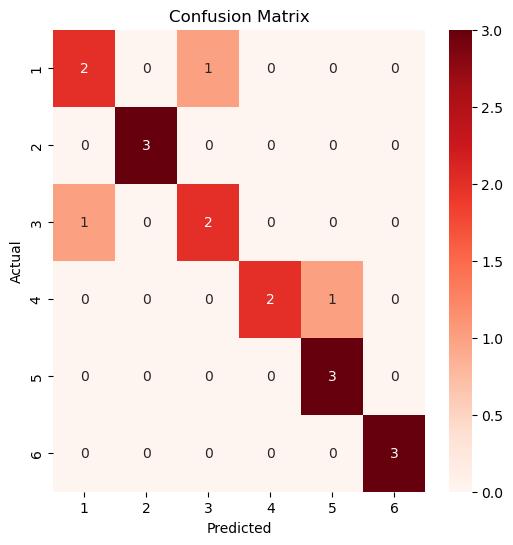

In [ ]:


from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
import seaborn as sns

print("Decision Tree Classifier Results:")

print("Accuracy: ",accuracy_score(y_test_dt, y_pred_dt))
print("Precision: ",precision_score(y_test_dt, y_pred_dt,average='macro'))
print("Recall: ",recall_score(y_test_dt, y_pred_dt,average='macro'))


cm = confusion_matrix(y_test_dt, y_pred_dt)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=range(1, 7), yticklabels=range(1, 7))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("Few Shot Learning Results:")

print("Accuracy: ",accuracy_score(true_labels, predictions))
print("Precision: ",precision_score(true_labels, predictions,average='macro'))
print("Recall: ",recall_score(true_labels, predictions,average='macro'))


cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=range(1, 7), yticklabels=range(1, 7))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Decision Tree Classifier Results:
Accuracy:  0.8333333333333334
Precision:  0.8361111111111111
Recall:  0.8333333333333334


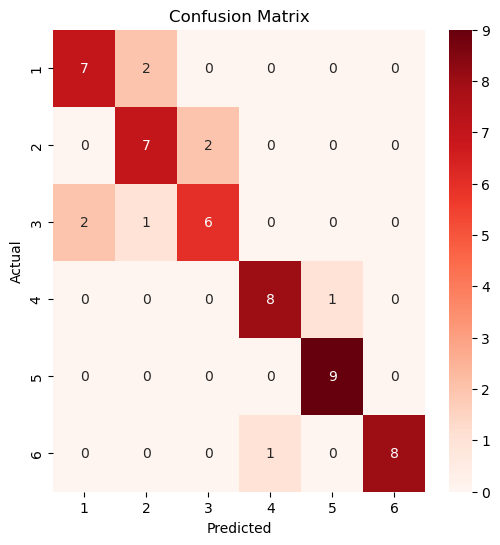

Few Shot Learning Results:
Accuracy:  0.8333333333333334
Precision:  0.8472222222222222
Recall:  0.8333333333333334


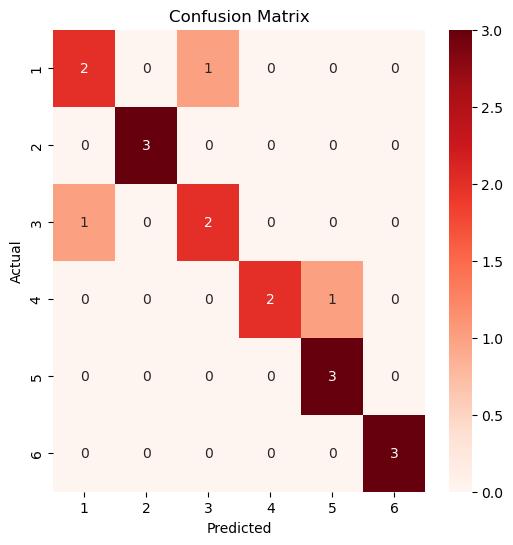

In [ ]:


from sklearn.tree import DecisionTreeClassifier

dt=DecisionTreeClassifier(random_state=0)
X_train_dt = X_train_pca_20
y_train_dt = y_train
dt.fit(X_train_dt,y_train_dt)
X_test_dt =X_test_pca_20
y_test_dt = y_test
y_pred_dt = dt.predict(X_test_dt)



from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
import seaborn as sns

print("Decision Tree Classifier Results:")

print("Accuracy: ",accuracy_score(y_test_dt, y_pred_dt))
print("Precision: ",precision_score(y_test_dt, y_pred_dt,average='macro'))
print("Recall: ",recall_score(y_test_dt, y_pred_dt,average='macro'))


cm = confusion_matrix(y_test_dt, y_pred_dt)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=range(1, 7), yticklabels=range(1, 7))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("Few Shot Learning Results:")

print("Accuracy: ",accuracy_score(true_labels, predictions))
print("Precision: ",precision_score(true_labels, predictions,average='macro'))
print("Recall: ",recall_score(true_labels, predictions,average='macro'))


cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=range(1, 7), yticklabels=range(1, 7))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Question 2:Quantitatively compare the accuracy of Few-Shot Learning with Decision Trees (You may use a subset of the test set if you encounter rate-limiting issues). Which method performs better? Why?
Answer:

**Accuracy:**

- **Few-Shot Learning:** 0.83
- **Decision Tree with Same Number of Examples:** 0.55
- **Decision Tree with Entire Training Data:** 0.83

1) **Few-Shot Learning vs. Decision Tree (Same Number of Examples):**

   - **Accuracy:** Few-Shot Learning significantly outperforms the Decision Tree trained with the same number of examples (0.83 vs. 0.55). This indicates that Few-Shot Learning is more efficient at learning from a limited number of examples, possibly due to leveraging pre-trained models or more sophisticated learning algorithms.

2) **Few-Shot Learning vs. Decision Tree (Entire Training Data):**

   - **Accuracy:** When the Decision Tree is trained with the entire training data, it achieves the same accuracy as Few-Shot Learning (0.83). This suggests that the Decision Tree model requires more data to achieve the same performance level as Few-Shot Learning.


Test Case 21 (Excluded Activity: SITTING):
Predicted label for the query input: 5
True label for the query input: 4
--------------------------------------------------
Test Case 26 (Excluded Activity: SITTING):
Predicted label for the query input: 6
True label for the query input: 4
--------------------------------------------------
Test Case 28 (Excluded Activity: SITTING):
Predicted label for the query input: 5
True label for the query input: 4
--------------------------------------------------
Test Case 33 (Excluded Activity: SITTING):
Predicted label for the query input: 6
True label for the query input: 4
--------------------------------------------------
Test Case 34 (Excluded Activity: SITTING):
Predicted label for the query input: 6
True label for the query input: 4
--------------------------------------------------
Test Case 44 (Excluded Activity: SITTING):
Predicted label for the query input: 6
True label for the query input: 4
-------------------------------------------------

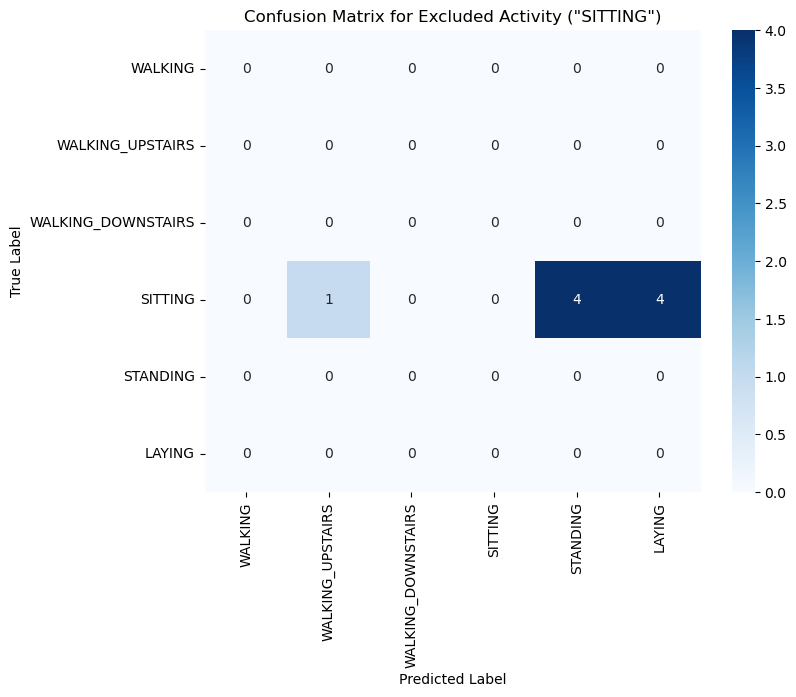

Total tokens used: 163468


In [ ]:
# Exclude "SITTING" (label 4) from the few-shot examples
excluded_label = 4

print("Excluded Activity: ", activity_labels[excluded_label])

few_shot_examples = [
    {"input": X_train_pca_20[i].tolist(), "label": y_train[i]} 
    for i in few_shot_indices if y_train[i] != excluded_label
]

# Step 3: Select test samples specifically from the excluded activity
selected_indices = []
samples_per_activity = 10  # Number of test samples from the excluded activity

for i, label in enumerate(y_test):
    if label == excluded_label and len(selected_indices) < samples_per_activity:
        selected_indices.append(i)

# Store predictions and true labels
predictions = []
true_labels = []

# Step 4: Test the excluded activity cases
for idx in selected_indices:
    query_input = X_test_pca_20[idx].tolist()
    true_label = y_test[idx]
    prompt = create_few_shot_prompt(few_shot_examples, query_input)
    
    # Step 5: Make the API call using ChatGroq
    answer = make_api_call(prompt)
    
    # Store predictions and true labels
    predicted_label = int(answer.content.strip())
    
    predictions.append(predicted_label)
    true_labels.append(true_label)
    
    # Print the predicted and true labels
    print(f"Test Case {idx + 1} (Excluded Activity: {activity_labels[true_label]}):")
    print(f"Predicted label for the query input: {predicted_label}")
    print(f"True label for the query input: {true_label}")
    print("-" * 50)

# Calculate confusion matrix and accuracy for the excluded activity
conf_matrix = confusion_matrix(true_labels, predictions, labels=[1, 2, 3, 4, 5, 6])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], yticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Excluded Activity ("SITTING")')
plt.show()

# Print token usage
print(f"Total tokens used: {token_count}")


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

few_shot_indices = []
samples_per_activity = 5  # Set the desired number of samples per activity for few-shot examples
activity_count = {i: 0 for i in range(1, 7)}  # Dictionary to track count of selected samples for each activity

# Loop through the training data to select even samples
for i, label in enumerate(y_train):
    if activity_count[label] < samples_per_activity:
        few_shot_indices.append(i)
        activity_count[label] += 1
    if all(count == samples_per_activity for count in activity_count.values()):
        break

# Create the few-shot examples with even distribution
few_shot_examples = [
    {"input": X_train_pca_20[i].tolist(), "label": y_train[i]} for i in few_shot_indices
]
    
# Calculate mean and standard deviation for each feature across the training data
means = np.mean(X_train_pca_20, axis=0)
std_devs = np.std(X_train_pca_20, axis=0)


# Generate random test data with the same dimensions as X_test_pca_20
num_samples = 18  # Same number of samples as in selected_indices
num_features = X_test_pca_20.shape[1]  # Same number of features as in X_test_pca_20

# Create random data using normal distribution based on training data statistics
random_data = np.random.normal(loc=means, scale=std_devs, size=(num_samples, num_features)).tolist()
print("Random Data Shape: ", len(random_data), len(random_data[0]))

# Test the model with random data
random_predictions = []
for query_input in random_data:
    prompt = create_few_shot_prompt(few_shot_examples, query_input)
    
    # Make the API call using ChatGroq
    answer = make_api_call(prompt)
    
    # Store predictions
    predicted_label = int(answer.content.strip())
    random_predictions.append(predicted_label)
    print(f"Predicted label for the random query input: {predicted_label}")


Random Data Shape:  18 20
Predicted label for the random query input: 3
Predicted label for the random query input: 2
Predicted label for the random query input: 2
Predicted label for the random query input: 4
Predicted label for the random query input: 2
Predicted label for the random query input: 2
Predicted label for the random query input: 4
Predicted label for the random query input: 2
Predicted label for the random query input: 1
Predicted label for the random query input: 2
Predicted label for the random query input: 3
Predicted label for the random query input: 4
Predicted label for the random query input: 1
Predicted label for the random query input: 1
Predicted label for the random query input: 4
Predicted label for the random query input: 1
Predicted label for the random query input: 2
Predicted label for the random query input: 3
